In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import cluster
import matplotlib.pyplot as plt
from scipy import ndimage, signal
from skimage import color, morphology

In [6]:
images_path = os.path.join('dataset', 'images')
DS = pd.read_csv(os.path.join('dataset', 'dataset.csv'))

def get(filename):
    return np.array(Image.open(os.path.join(images_path, filename)))

def seg(img):
    kn = (15, 15)
    im_mean = ndimage.uniform_filter(img, kn)
    im_sqr_mean = ndimage.uniform_filter(img**2, kn)
    im_var = ndimage.minimum_filter(im_sqr_mean - im_mean**2, (5, 5))
    data = im_var.flatten()
    km = cluster.KMeans(3)
    cluster_id = km.fit_predict(data.reshape(-1, 1))
    min_bin = None
    f = 0
    for ii in np.unique(cluster_id):
        subset = data[cluster_id == ii]
        hist, bins = np.histogram(subset, bins=50)
        if min_bin == None or bins.max() < min_bin:
            min_bin = bins.max()
            f = bins[:-1][hist == hist.min()][-1]
    imth = im_var < f
    mask = ndimage.binary_dilation(ndimage.binary_fill_holes(morphology.area_opening(imth, area_threshold=200)))
    return mask

def fft2d(image):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

def freq_peaks(image):
    fft = np.abs(fft2d(image))
    xfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[0], 1))
    yfreqs = np.fft.ifftshift(np.fft.fftfreq(fft.shape[1], 1))
    
    ymean = np.mean(fft, axis=1)
    xmean = np.mean(fft, axis=0)
    
    (ypeaks, _), (xpeaks, _) = signal.find_peaks(ymean), signal.find_peaks(xmean)
    Py = ypeaks[ymean[ypeaks] == ymean[ypeaks][np.isin(ymean[ypeaks], ymean[yfreqs < yfreqs[ymean == ymean[ypeaks].max()][0]])].max()]
    Px = xpeaks[xmean[xpeaks] == xmean[xpeaks][np.isin(xmean[xpeaks], xmean[xfreqs < xfreqs[xmean == xmean[xpeaks].max()][0]])].max()]
    
    return np.abs(xfreqs[Px][0]), np.abs(xfreqs[Py][0])

def predict_area(image):
    gray_image = color.rgb2gray(image)
    S = seg(gray_image)
    fx, fy = freq_peaks(gray_image)
    return np.sum(S)*fx*fy

In [7]:
%%time
DS['predict'] = [predict_area(get(filename)) for filename in DS.filename]
DS

,filename,area,predict
0,0.jpg,100.473,94.250443
1,1.jpg,127.880,119.218826
2,2.jpg,161.820,146.012589
3,3.jpg,190.003,169.497955
4,4.jpg,22.713,16.163513
...,...,...,...
350,350.jpg,98.599,102.461243
351,351.jpg,98.599,103.822754
352,352.jpg,98.599,102.441467
353,353.jpg,98.599,100.892273


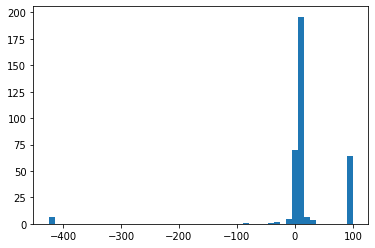

In [66]:
DS['rel'] = (DS.area - DS.predict)/DS.area*100
plt.hist(DS['rel'], bins=50)
plt.show()

<BarContainer object of 355 artists>

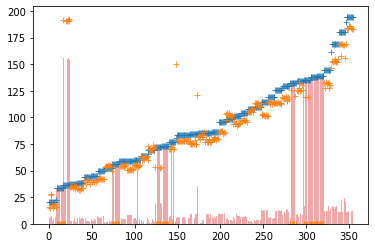

In [46]:
dss = DS.sort_values('area')
plt.plot(dss.area.values, '+', alpha=0.8, label='Valor Real')
plt.plot(dss.predict.values, '+', alpha=0.8, label='Valor Encontrado')
plt.bar(np.arange(len(DS)), np.abs(dss.area.values - dss.predict.values), color='tab:red', alpha=0.4, label='Erro absoluto')
#plt.legend()

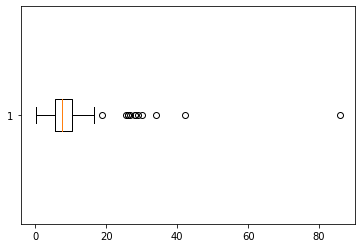

In [75]:
error = np.abs(DS[DS.predict != 0].rel[np.abs(DS.rel) < 100])
plt.boxplot(error, vert=False)
plt.show()

In [76]:
error.describe()

count    285.000000
mean       8.577486
std        7.148452
min        0.136376
25%        5.432521
50%        7.465504
75%       10.301126
max       85.931657
Name: rel, dtype: float64

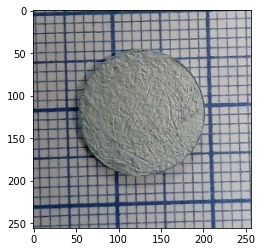

In [70]:
plt.imshow(get(DS[DS.predict == 0].filename.sample().values[0]))